In [1]:
import pandas as pd
import numpy as np
import LSTM_preprocessing as pre
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mysql.connector
from mysql.connector import Error
import warnings
warnings.filterwarnings("ignore")

In [2]:
connection = pre.connect_to_database()

if connection:
    # Query merged data
    merged_df = pre.query_merged_crypto_data(connection)

    if merged_df is not None and not merged_df.empty:
        # Display first few rows of the DataFrame
        print("\nMerged DataFrame:")
        print(merged_df.head())

    else:
        print("\nNo data found after merging.")

    # Close the connection
    pre.query_quit(connection)

Connected to MySQL database, MySQL Server version:  8.0.39

Merged DataFrame:
   id crypto_symbol                date lending_rate borrowing_rate  \
0   1       BATUSDT 2020-12-02 14:00:00   -50.000000     -50.000000   
1   2       BATUSDT 2020-12-02 15:00:00   -50.000000     -50.000000   
2   3       BATUSDT 2020-12-02 16:00:00   -50.000000     -50.000000   
3   4       BATUSDT 2020-12-02 17:00:00   -50.000000     -50.000000   
4   5       BATUSDT 2020-12-02 18:00:00   -50.000000     -50.000000   

  utilization_rate stable_borrow_rate crypto_symbol                date  high  \
0       -50.000000           0.030000       BATUSDT 2020-12-02 14:00:00  0.24   
1       -50.000000           0.030000       BATUSDT 2020-12-02 15:00:00  0.24   
2         0.013598           0.030000       BATUSDT 2020-12-02 16:00:00  0.24   
3         0.014834           0.030000       BATUSDT 2020-12-02 17:00:00  0.24   
4         0.014834           0.030000       BATUSDT 2020-12-02 18:00:00  0.25   

    low 

In [3]:
# Drop the second occurrence of a specific column
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
# data without NA rows if we needed 
filtered_df = merged_df[(merged_df['borrowing_rate'] != -50)&(merged_df['lending_rate'] != -50)&(merged_df['utilization_rate'] != -50)]
filtered_df.reset_index(inplace=True, drop=True)
# date formatting
filtered_df['date'] = pd.to_datetime(filtered_df['date'])
# taking the columns we want and converting them to floats
filtered_df = filtered_df[['crypto_symbol', 'date', 'lending_rate',	'borrowing_rate','utilization_rate','close', 'volume']]
filtered_df[['lending_rate',	'borrowing_rate','utilization_rate','close', 'volume']] = filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']].astype(float)


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

def train_and_evaluate(inputs, outputs, test_size=0.2, valid_size=0.25, random_state=42, epochs=50, batch_size=100):
    # Clearing the TensorFlow session to ensure the model starts with fresh weights and biases
    tf.keras.backend.clear_session()

    # Setting the seed for reproducibility
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

    # Splitting the data into train+validation and test sets
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(
        inputs, outputs, test_size=test_size, random_state=random_state)

    # Splitting the train+validation set into separate training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_valid, y_train_valid, test_size=valid_size, random_state=random_state)

    # # Printing the shapes of the datasets
    # print("Training data shape:", X_train.shape)
    # print("Validation data shape:", X_valid.shape)
    # print("Test data shape:", X_test.shape)
    # print("Training labels shape:", y_train.shape)
    # print("Validation labels shape:", y_valid.shape)
    # print("Test labels shape:", y_test.shape)

    # Model definition
    model = Sequential([
        LSTM(48, activation='tanh', input_shape=(inputs.shape[1], inputs.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(48, activation='tanh'),
        Dropout(0.2),
        Dense(outputs.shape[1] * outputs.shape[2]),
    ])

    # Compiling the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Training the model
    history = model.fit(
        X_train, y_train.reshape(y_train.shape[0], -1),
        epochs=epochs,
        batch_size=batch_size,
        verbose = 0,
        validation_data=(X_valid, y_valid.reshape(y_valid.shape[0], -1))
    )

    # Plotting training and validation loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Making predictions on the test set
    test_predictions = model.predict(X_test)
    return y_test, test_predictions

def rate_growth(data, prediction, threshold_factor=0.1):
    # Calculate changes for data
    changes_data = data[:, 23, 0] - data[:, 0, 0]
    std_data = np.std(changes_data)
    threshold_data = threshold_factor * std_data

    # Classify growth for data
    growth_data = []
    for change in changes_data:
        if change > threshold_data:
            growth_data.append(1)
        elif change < -threshold_data:
            growth_data.append(-1)
        else:
            growth_data.append(0)

    # Calculate changes for prediction
    changes_prediction = prediction[:, 23] - prediction[:, 0]
    std_prediction = np.std(changes_prediction)
    threshold_prediction = threshold_factor * std_prediction

    # Classify growth for prediction
    growth_prediction = []
    for change in changes_prediction:
        if change > threshold_prediction:
            growth_prediction.append(1)
        elif change < -threshold_prediction:
            growth_prediction.append(-1)
        else:
            growth_prediction.append(0)

    return growth_data, growth_prediction

def classification_metrics(y_true, y_pred):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Visualization of the confusion matrix using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['-1', '0', '1'], yticklabels=['-1', '0', '1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # Printing classification metrics
    print("Classification Metrics:")
    print("Accuracy: {:.2f}".format(accuracy))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))
    
    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['-1', '0', '1']))
    return accuracy, precision, recall, f1

BATUSDT 28159
rows with valid returns: 27850
input size (10222, 48, 5)
output size (10222, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and BATUSDT


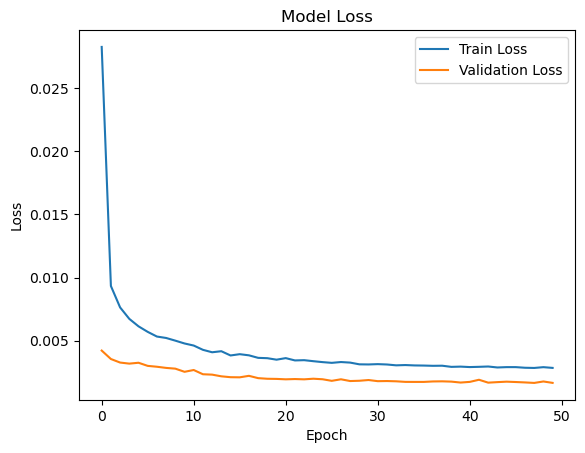

64/64 [==============================] - 1s 6ms/step


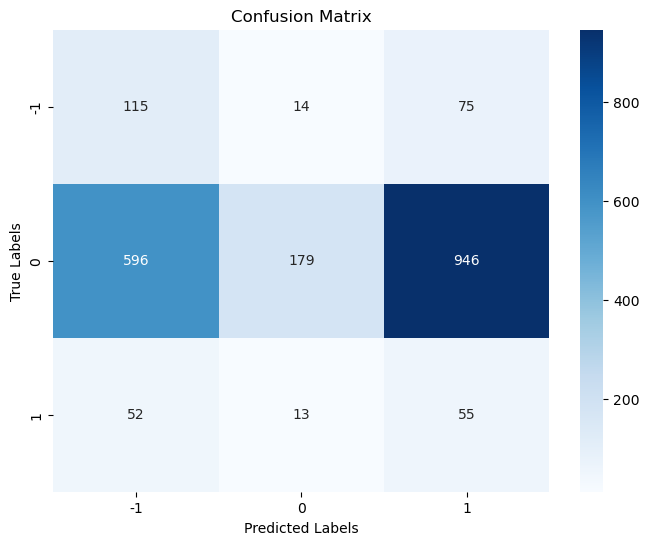

Classification Metrics:
Accuracy: 0.17
Precision: 0.36
Recall: 0.38
F1 Score: 0.17

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.15      0.56      0.24       204
           0       0.87      0.10      0.19      1721
           1       0.05      0.46      0.09       120

    accuracy                           0.17      2045
   macro avg       0.36      0.38      0.17      2045
weighted avg       0.75      0.17      0.19      2045

for borrowing rate and BATUSDT


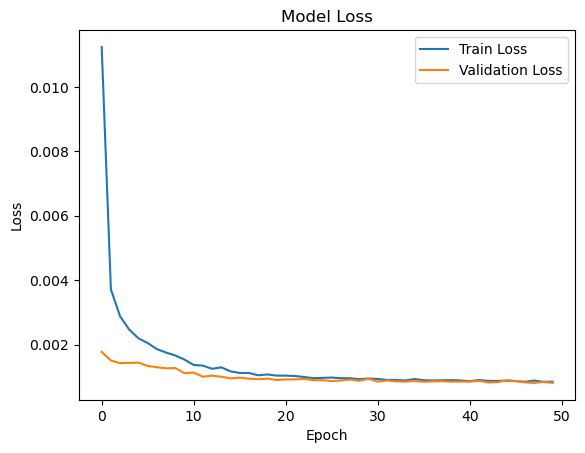

64/64 [==============================] - 1s 6ms/step


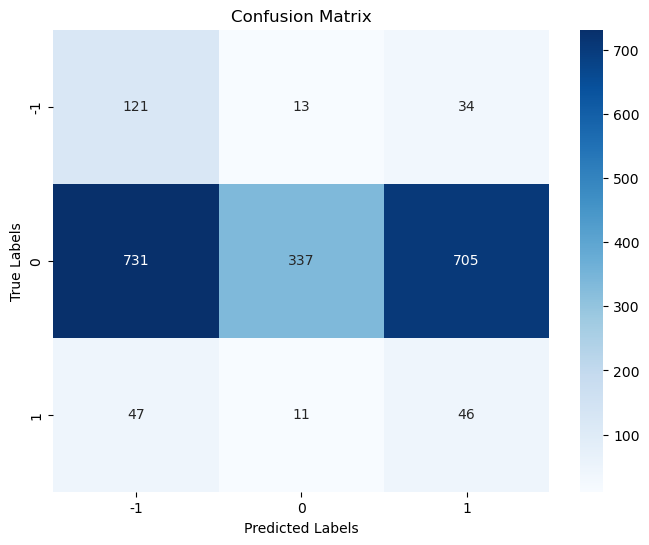

Classification Metrics:
Accuracy: 0.25
Precision: 0.38
Recall: 0.45
F1 Score: 0.22

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.13      0.72      0.23       168
           0       0.93      0.19      0.32      1773
           1       0.06      0.44      0.10       104

    accuracy                           0.25      2045
   macro avg       0.38      0.45      0.22      2045
weighted avg       0.82      0.25      0.30      2045

LINKUSDT 31934
rows with valid returns: 31598
input size (8765, 48, 5)
output size (8765, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and LINKUSDT


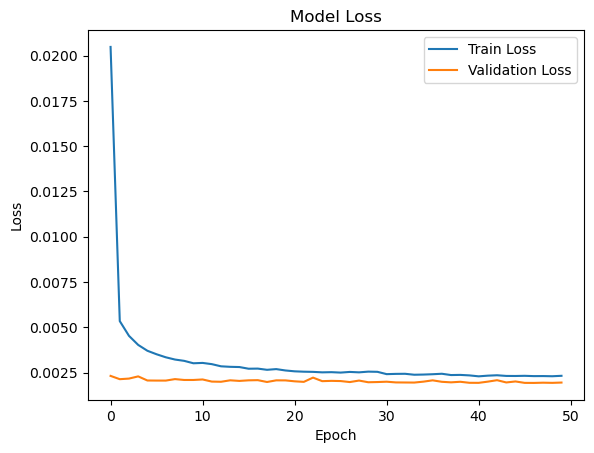

55/55 [==============================] - 1s 7ms/step


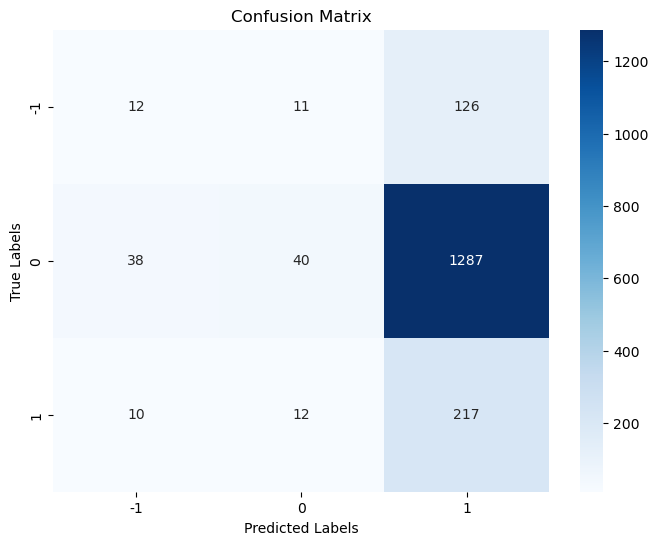

Classification Metrics:
Accuracy: 0.15
Precision: 0.32
Recall: 0.34
F1 Score: 0.13

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.20      0.08      0.11       149
           0       0.63      0.03      0.06      1365
           1       0.13      0.91      0.23       239

    accuracy                           0.15      1753
   macro avg       0.32      0.34      0.13      1753
weighted avg       0.53      0.15      0.09      1753

for borrowing rate and LINKUSDT


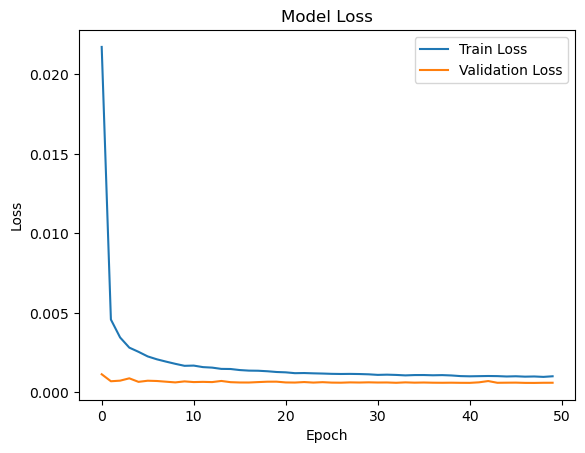

55/55 [==============================] - 1s 6ms/step


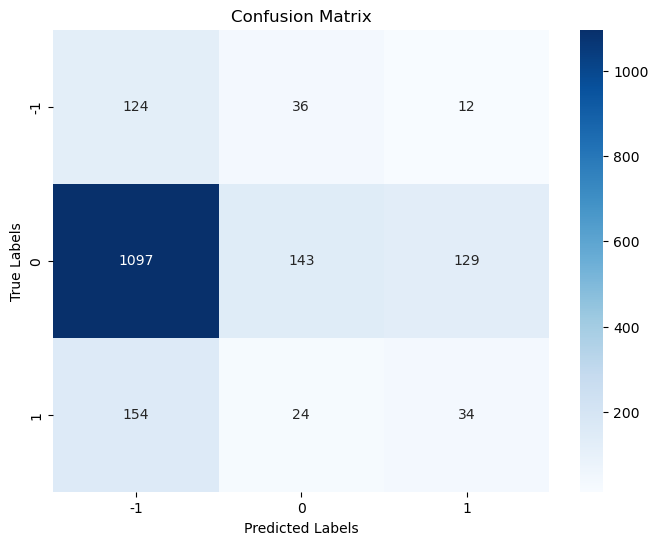

Classification Metrics:
Accuracy: 0.17
Precision: 0.33
Recall: 0.33
F1 Score: 0.17

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.09      0.72      0.16       172
           0       0.70      0.10      0.18      1369
           1       0.19      0.16      0.18       212

    accuracy                           0.17      1753
   macro avg       0.33      0.33      0.17      1753
weighted avg       0.58      0.17      0.18      1753

KNCUSDT 27690
rows with valid returns: 27474
input size (5137, 48, 5)
output size (5137, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and KNCUSDT


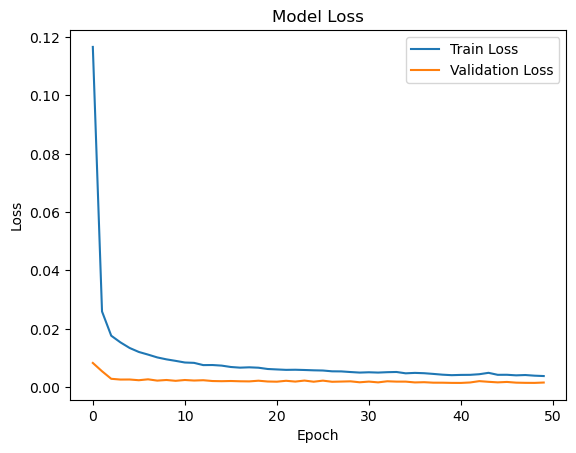

33/33 [==============================] - 1s 6ms/step


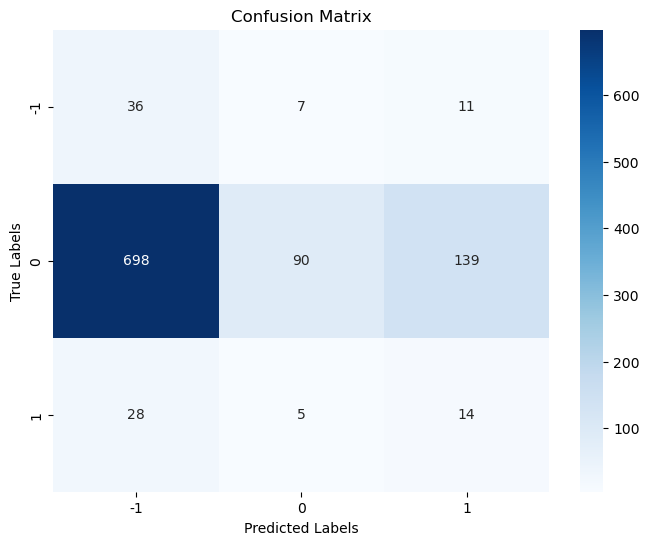

Classification Metrics:
Accuracy: 0.14
Precision: 0.34
Recall: 0.35
F1 Score: 0.13

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.05      0.67      0.09        54
           0       0.88      0.10      0.17       927
           1       0.09      0.30      0.13        47

    accuracy                           0.14      1028
   macro avg       0.34      0.35      0.13      1028
weighted avg       0.80      0.14      0.17      1028

for borrowing rate and KNCUSDT


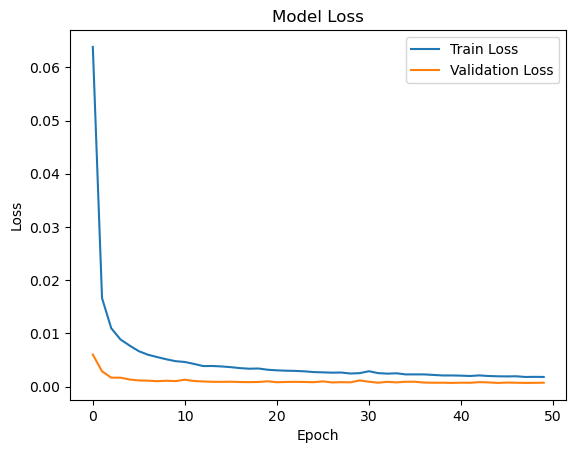

33/33 [==============================] - 1s 6ms/step


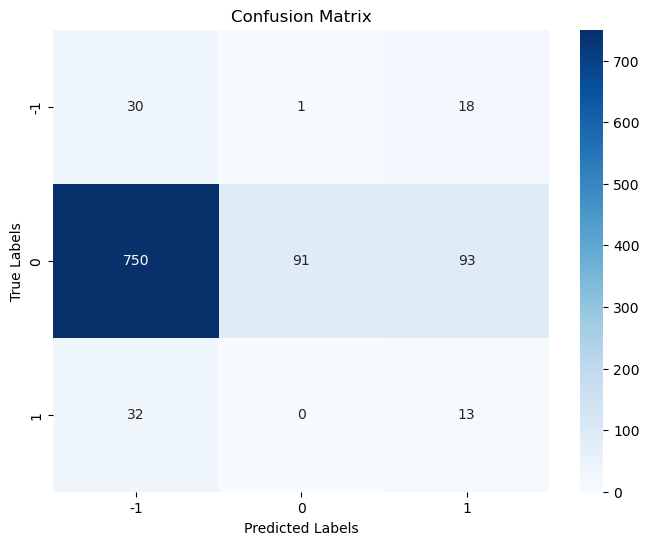

Classification Metrics:
Accuracy: 0.13
Precision: 0.38
Recall: 0.33
F1 Score: 0.13

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.04      0.61      0.07        49
           0       0.99      0.10      0.18       934
           1       0.10      0.29      0.15        45

    accuracy                           0.13      1028
   macro avg       0.38      0.33      0.13      1028
weighted avg       0.91      0.13      0.17      1028

MKRUSDT 30094
rows with valid returns: 29657
input size (7645, 48, 5)
output size (7645, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and MKRUSDT


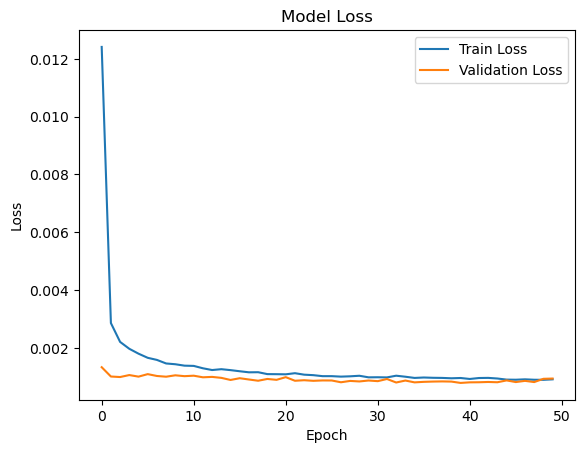

48/48 [==============================] - 1s 7ms/step


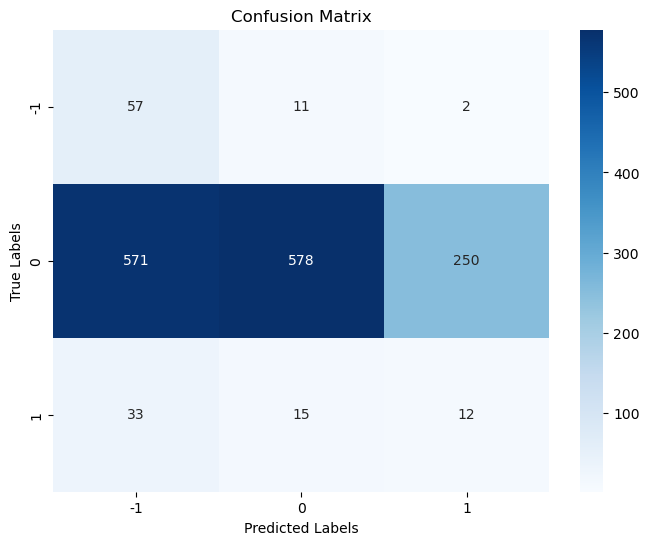

Classification Metrics:
Accuracy: 0.42
Precision: 0.36
Recall: 0.48
F1 Score: 0.27

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.09      0.81      0.16        70
           0       0.96      0.41      0.58      1399
           1       0.05      0.20      0.07        60

    accuracy                           0.42      1529
   macro avg       0.36      0.48      0.27      1529
weighted avg       0.88      0.42      0.54      1529

for borrowing rate and MKRUSDT


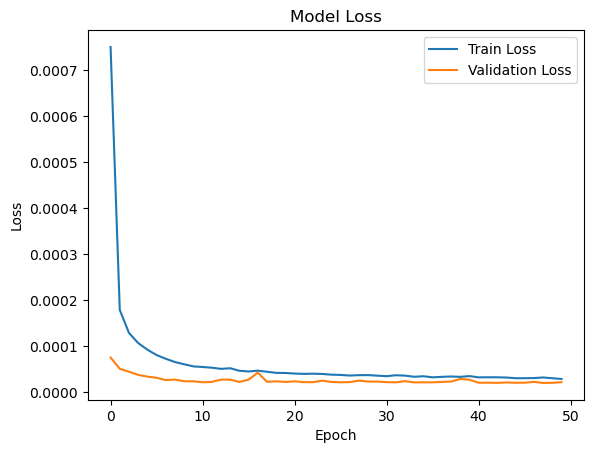

48/48 [==============================] - 1s 6ms/step


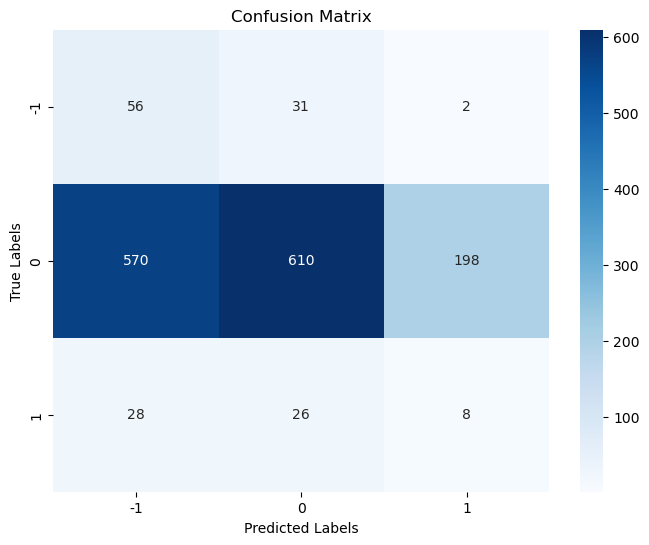

Classification Metrics:
Accuracy: 0.44
Precision: 0.35
Recall: 0.40
F1 Score: 0.27

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.09      0.63      0.15        89
           0       0.91      0.44      0.60      1378
           1       0.04      0.13      0.06        62

    accuracy                           0.44      1529
   macro avg       0.35      0.40      0.27      1529
weighted avg       0.83      0.44      0.55      1529

MANAUSDT 27145
rows with valid returns: 26560
input size (2858, 48, 5)
output size (2858, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and MANAUSDT


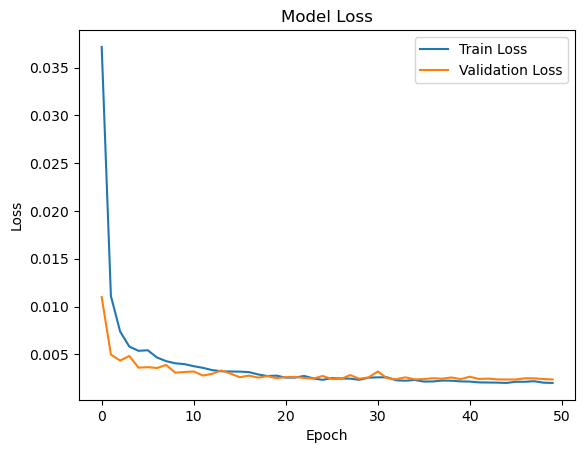

18/18 [==============================] - 1s 7ms/step


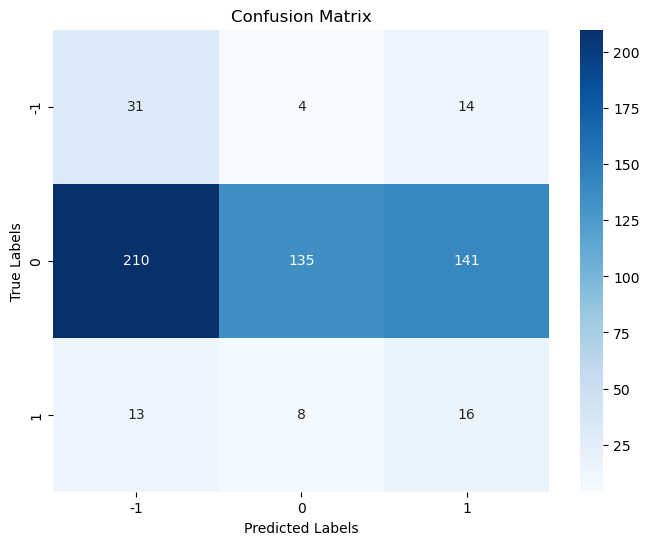

Classification Metrics:
Accuracy: 0.32
Precision: 0.38
Recall: 0.45
F1 Score: 0.26

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.12      0.63      0.20        49
           0       0.92      0.28      0.43       486
           1       0.09      0.43      0.15        37

    accuracy                           0.32       572
   macro avg       0.38      0.45      0.26       572
weighted avg       0.80      0.32      0.39       572

for borrowing rate and MANAUSDT


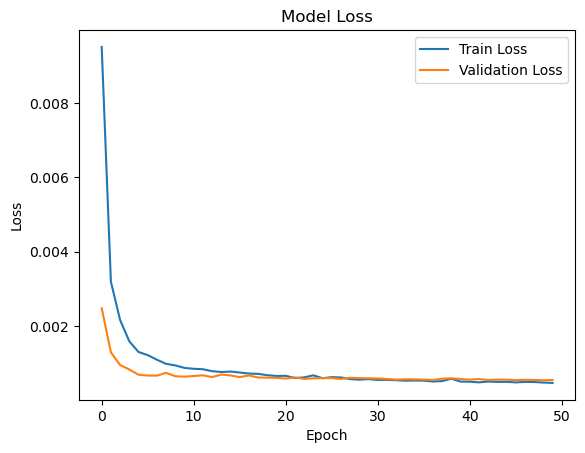

18/18 [==============================] - 1s 6ms/step


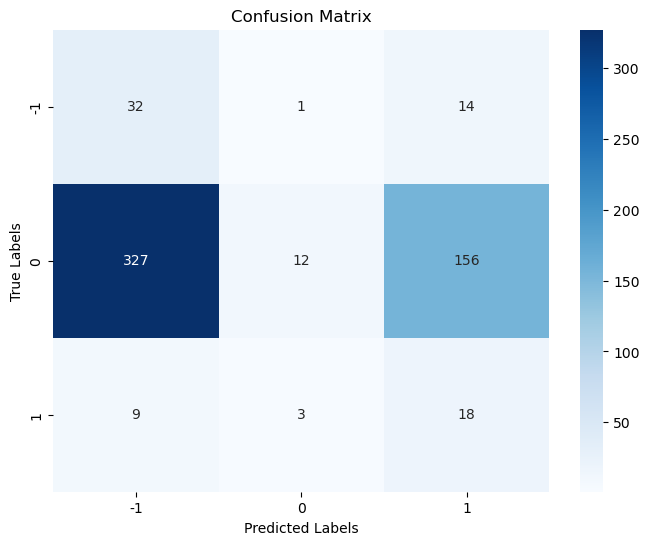

Classification Metrics:
Accuracy: 0.11
Precision: 0.31
Recall: 0.44
F1 Score: 0.12

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.09      0.68      0.15        47
           0       0.75      0.02      0.05       495
           1       0.10      0.60      0.17        30

    accuracy                           0.11       572
   macro avg       0.31      0.44      0.12       572
weighted avg       0.66      0.11      0.06       572

ZRXUSDT 28255
rows with valid returns: 28057
input size (11747, 48, 5)
output size (11747, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and ZRXUSDT


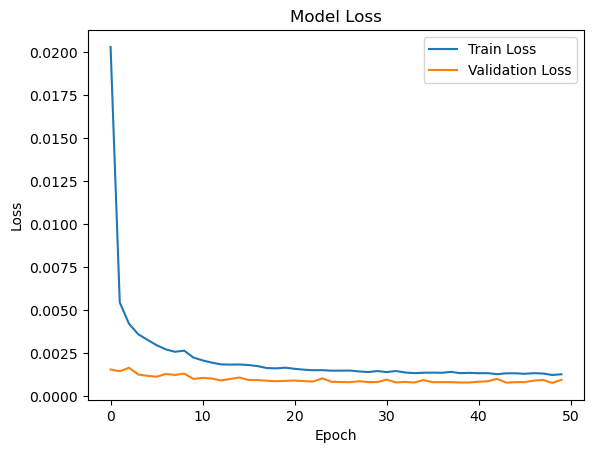

74/74 [==============================] - 1s 6ms/step


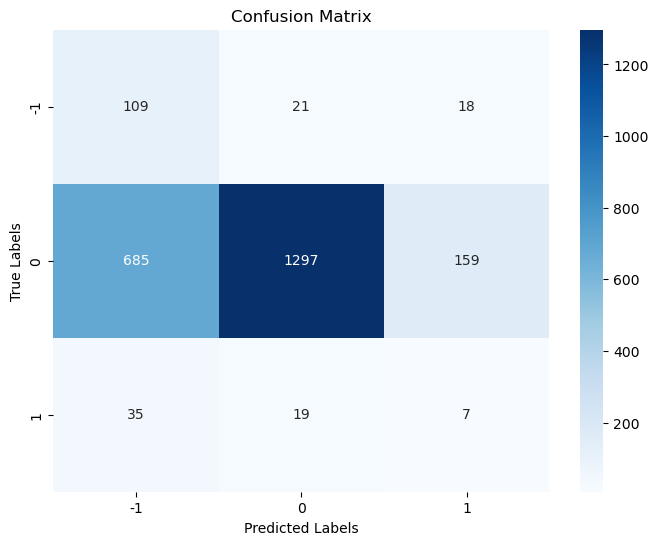

Classification Metrics:
Accuracy: 0.60
Precision: 0.38
Recall: 0.49
F1 Score: 0.34

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.13      0.74      0.22       148
           0       0.97      0.61      0.75      2141
           1       0.04      0.11      0.06        61

    accuracy                           0.60      2350
   macro avg       0.38      0.49      0.34      2350
weighted avg       0.89      0.60      0.70      2350

for borrowing rate and ZRXUSDT


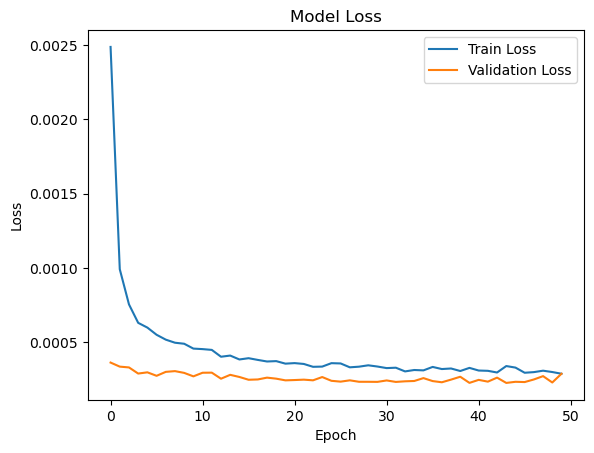

74/74 [==============================] - 1s 7ms/step


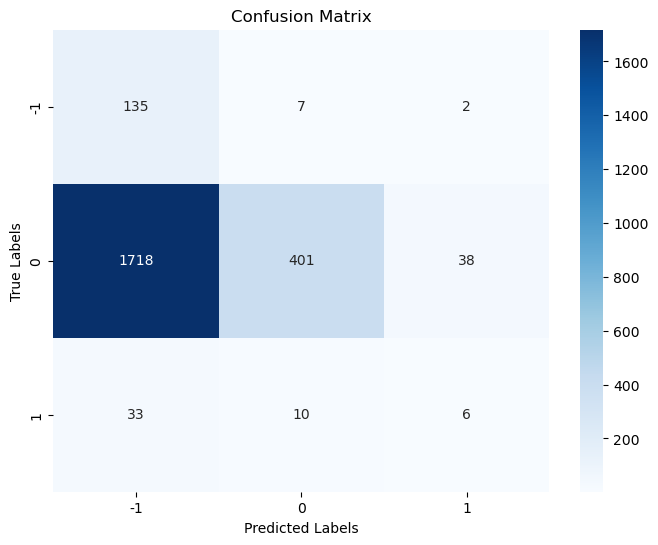

Classification Metrics:
Accuracy: 0.23
Precision: 0.39
Recall: 0.42
F1 Score: 0.19

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.07      0.94      0.13       144
           0       0.96      0.19      0.31      2157
           1       0.13      0.12      0.13        49

    accuracy                           0.23      2350
   macro avg       0.39      0.42      0.19      2350
weighted avg       0.89      0.23      0.30      2350

SNXUSDT 31087
rows with valid returns: 30477
input size (4984, 48, 5)
output size (4984, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and SNXUSDT


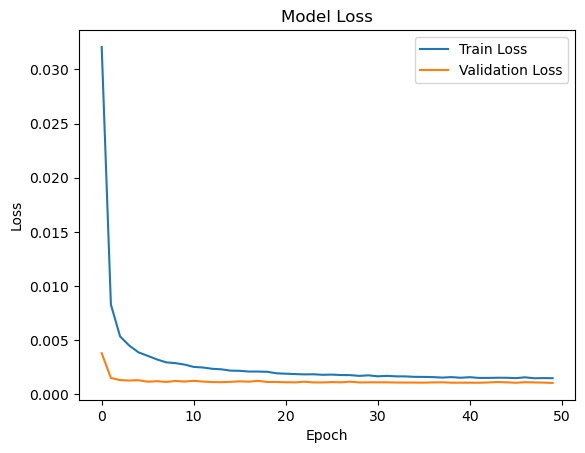

32/32 [==============================] - 1s 7ms/step


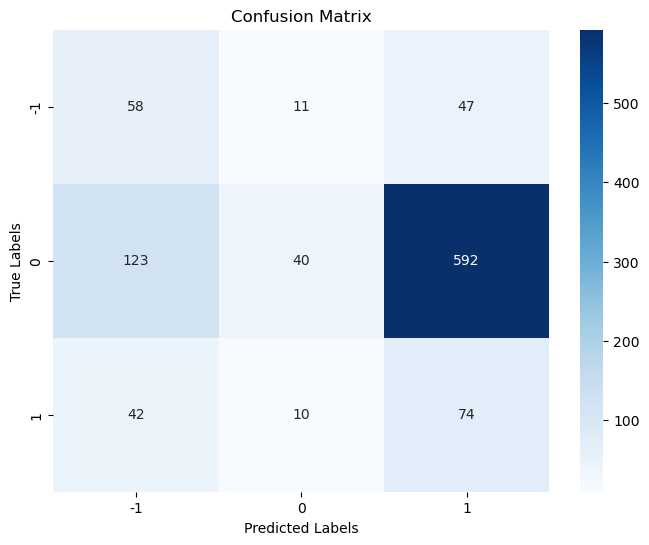

Classification Metrics:
Accuracy: 0.17
Precision: 0.34
Recall: 0.38
F1 Score: 0.21

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.26      0.50      0.34       116
           0       0.66      0.05      0.10       755
           1       0.10      0.59      0.18       126

    accuracy                           0.17       997
   macro avg       0.34      0.38      0.21       997
weighted avg       0.54      0.17      0.14       997

for borrowing rate and SNXUSDT


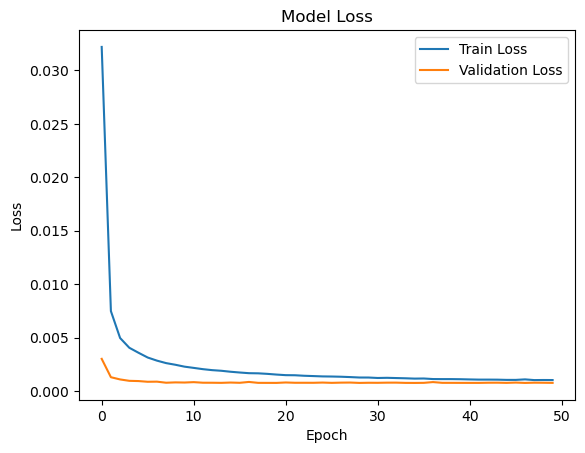

32/32 [==============================] - 1s 7ms/step


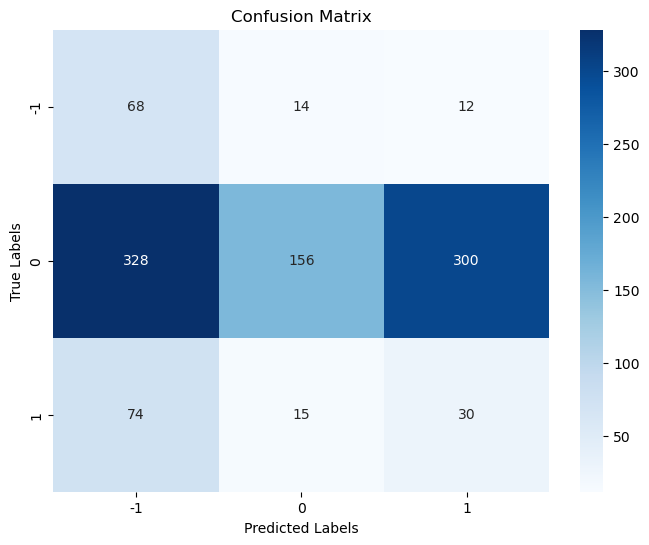

Classification Metrics:
Accuracy: 0.25
Precision: 0.36
Recall: 0.39
F1 Score: 0.23

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.14      0.72      0.24        94
           0       0.84      0.20      0.32       784
           1       0.09      0.25      0.13       119

    accuracy                           0.25       997
   macro avg       0.36      0.39      0.23       997
weighted avg       0.69      0.25      0.29       997

WBTCUSDT 11729
rows with valid returns: 11297
input size (244, 48, 5)
output size (244, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and WBTCUSDT


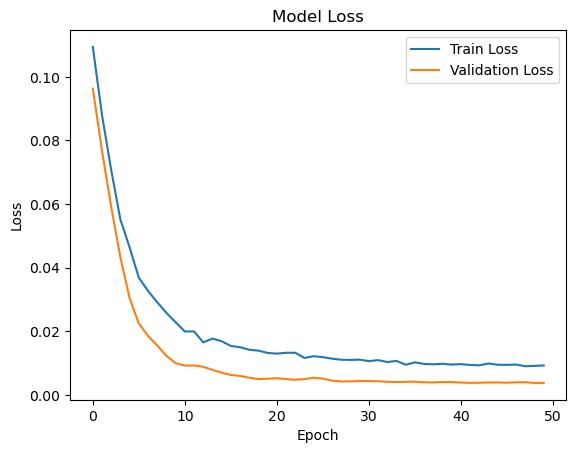

2/2 [==============================] - 1s 8ms/step


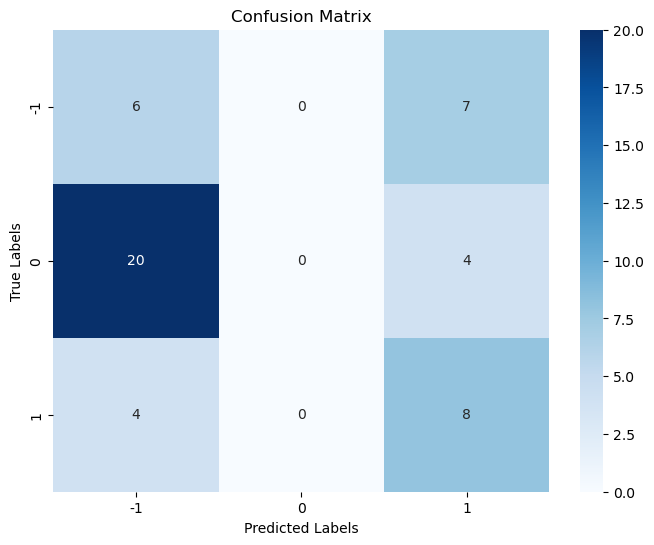

Classification Metrics:
Accuracy: 0.29
Precision: 0.21
Recall: 0.38
F1 Score: 0.27

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.20      0.46      0.28        13
           0       0.00      0.00      0.00        24
           1       0.42      0.67      0.52        12

    accuracy                           0.29        49
   macro avg       0.21      0.38      0.27        49
weighted avg       0.16      0.29      0.20        49

for borrowing rate and WBTCUSDT


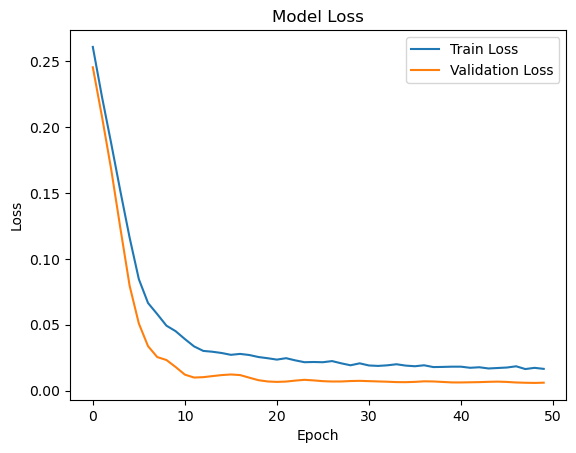

2/2 [==============================] - 1s 7ms/step


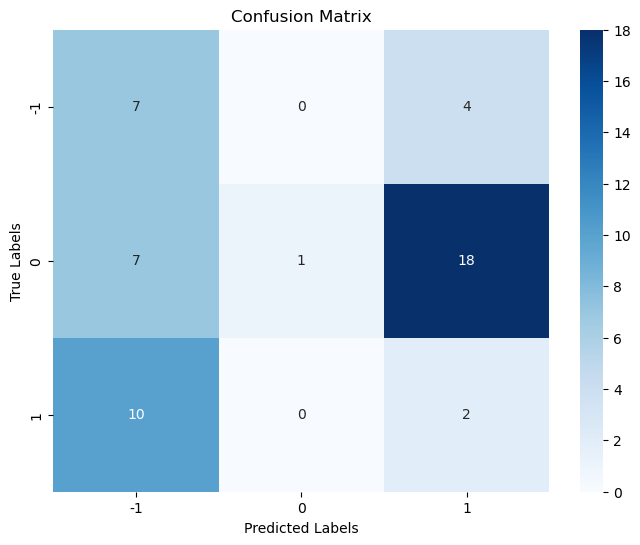

Classification Metrics:
Accuracy: 0.20
Precision: 0.46
Recall: 0.28
F1 Score: 0.20

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.29      0.64      0.40        11
           0       1.00      0.04      0.07        26
           1       0.08      0.17      0.11        12

    accuracy                           0.20        49
   macro avg       0.46      0.28      0.20        49
weighted avg       0.62      0.20      0.16        49

ENJUSDT 27034
rows with valid returns: 26606
input size (7331, 48, 5)
output size (7331, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and ENJUSDT


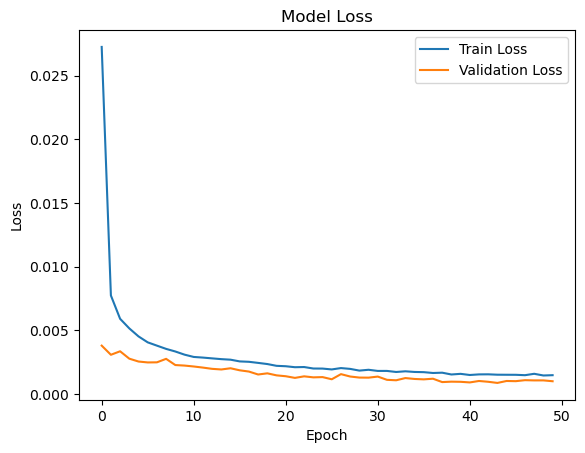

46/46 [==============================] - 1s 7ms/step


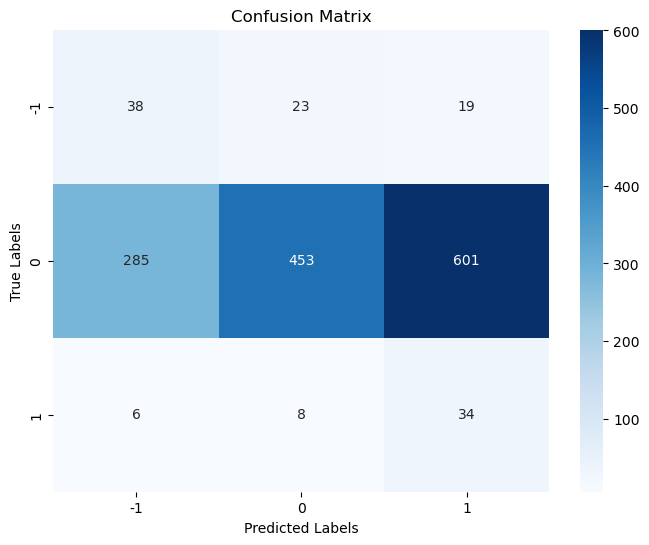

Classification Metrics:
Accuracy: 0.36
Precision: 0.37
Recall: 0.51
F1 Score: 0.26

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.12      0.47      0.19        80
           0       0.94      0.34      0.50      1339
           1       0.05      0.71      0.10        48

    accuracy                           0.36      1467
   macro avg       0.37      0.51      0.26      1467
weighted avg       0.86      0.36      0.47      1467

for borrowing rate and ENJUSDT


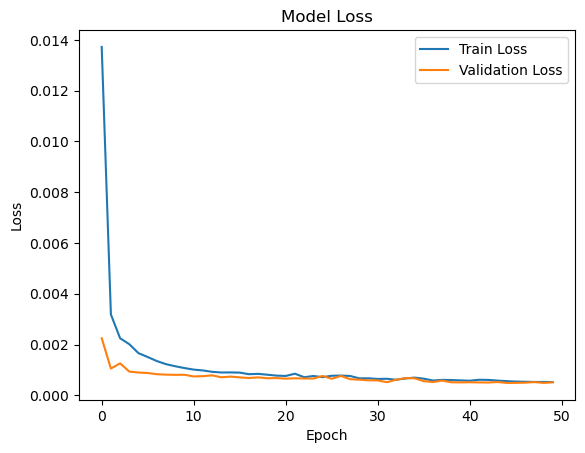

46/46 [==============================] - 1s 7ms/step


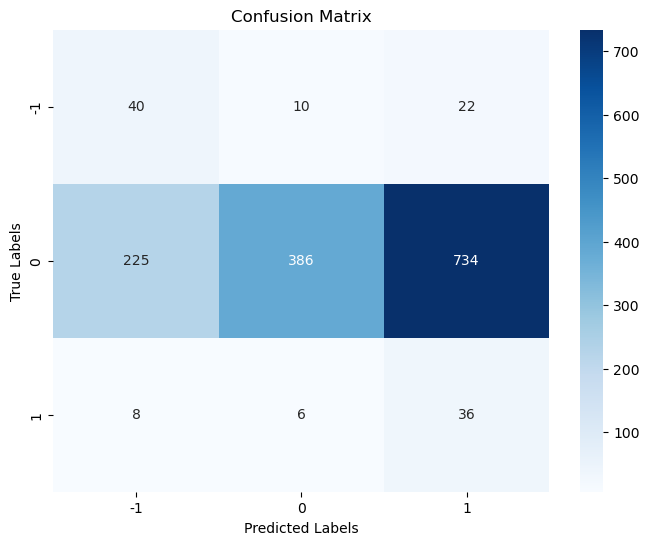

Classification Metrics:
Accuracy: 0.31
Precision: 0.38
Recall: 0.52
F1 Score: 0.25

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.15      0.56      0.23        72
           0       0.96      0.29      0.44      1345
           1       0.05      0.72      0.09        50

    accuracy                           0.31      1467
   macro avg       0.38      0.52      0.25      1467
weighted avg       0.89      0.31      0.42      1467

RENUSDT 27658
rows with valid returns: 27296
input size (7834, 48, 5)
output size (7834, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and RENUSDT


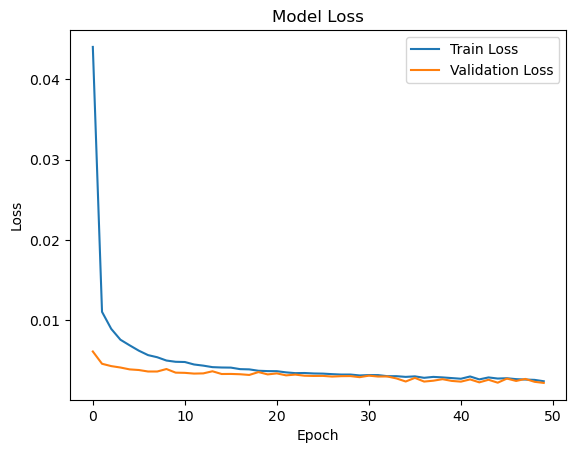

49/49 [==============================] - 1s 7ms/step


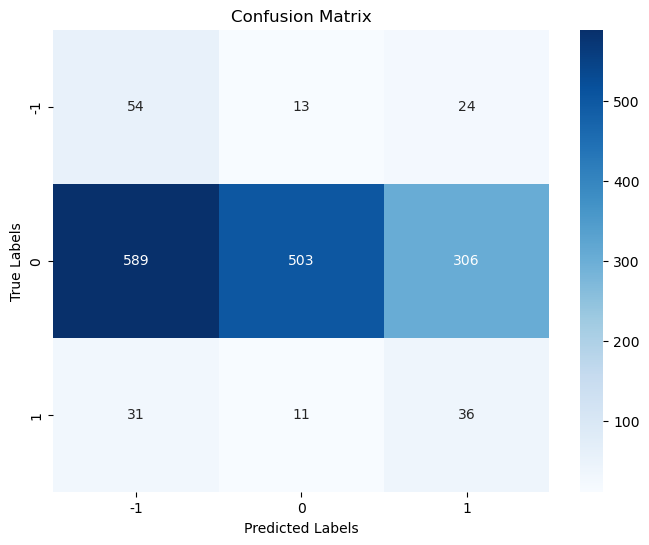

Classification Metrics:
Accuracy: 0.38
Precision: 0.38
Recall: 0.47
F1 Score: 0.28

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.08      0.59      0.14        91
           0       0.95      0.36      0.52      1398
           1       0.10      0.46      0.16        78

    accuracy                           0.38      1567
   macro avg       0.38      0.47      0.28      1567
weighted avg       0.86      0.38      0.48      1567

for borrowing rate and RENUSDT


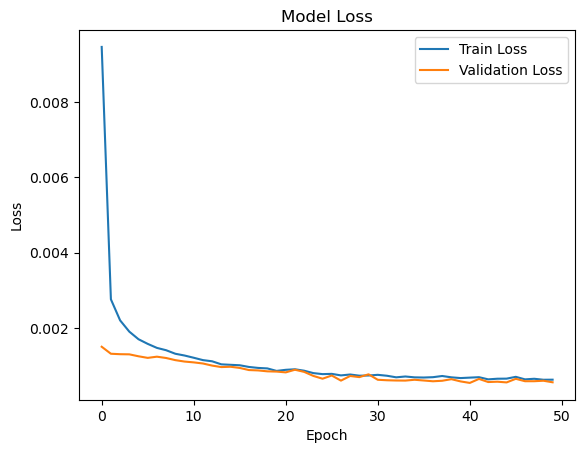

49/49 [==============================] - 1s 10ms/step


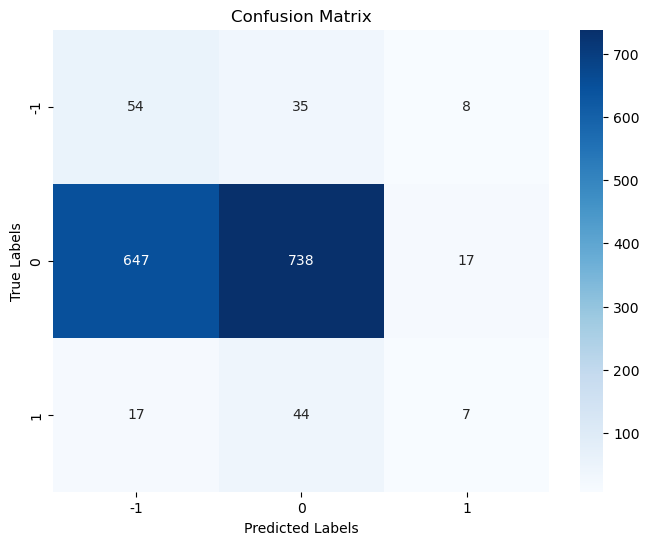

Classification Metrics:
Accuracy: 0.51
Precision: 0.40
Recall: 0.40
F1 Score: 0.31

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.08      0.56      0.13        97
           0       0.90      0.53      0.67      1402
           1       0.22      0.10      0.14        68

    accuracy                           0.51      1567
   macro avg       0.40      0.40      0.31      1567
weighted avg       0.82      0.51      0.61      1567

YFIUSDT 29900
rows with valid returns: 29426
input size (2856, 48, 5)
output size (2856, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and YFIUSDT


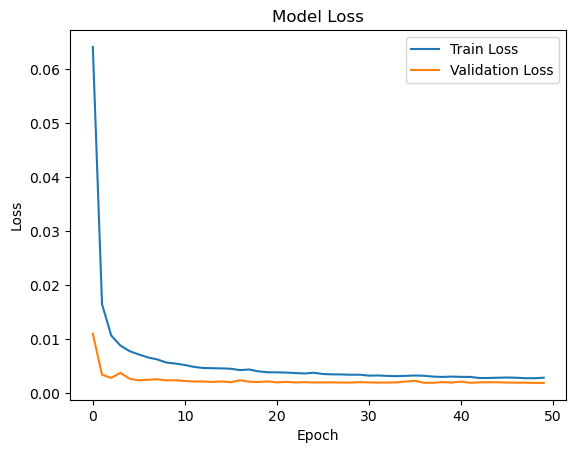

18/18 [==============================] - 1s 7ms/step


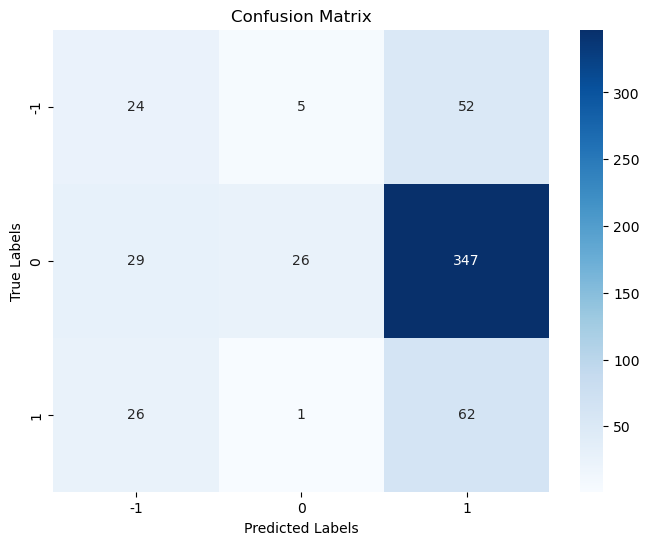

Classification Metrics:
Accuracy: 0.20
Precision: 0.42
Recall: 0.35
F1 Score: 0.22

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.30      0.30      0.30        81
           0       0.81      0.06      0.12       402
           1       0.13      0.70      0.23        89

    accuracy                           0.20       572
   macro avg       0.42      0.35      0.22       572
weighted avg       0.63      0.20      0.16       572

for borrowing rate and YFIUSDT


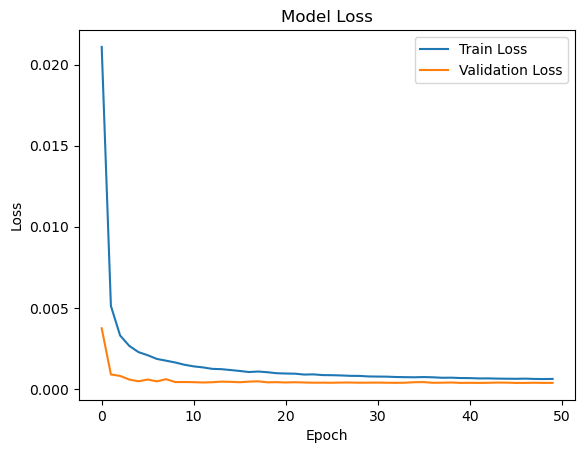

18/18 [==============================] - 1s 9ms/step


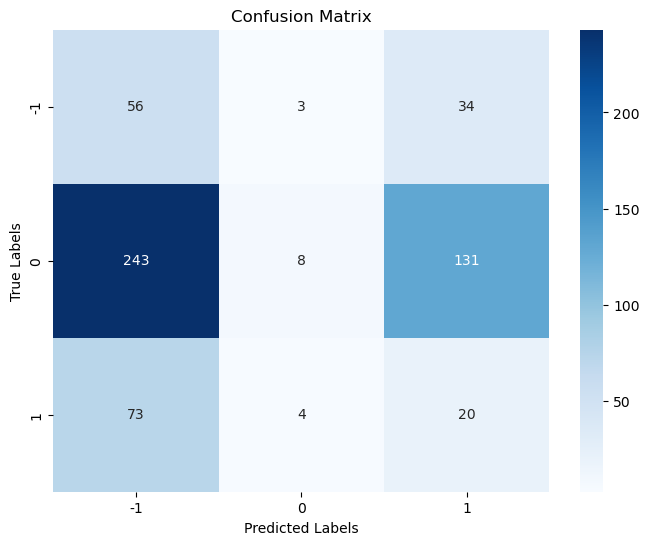

Classification Metrics:
Accuracy: 0.15
Precision: 0.26
Recall: 0.28
F1 Score: 0.14

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.15      0.60      0.24        93
           0       0.53      0.02      0.04       382
           1       0.11      0.21      0.14        97

    accuracy                           0.15       572
   macro avg       0.26      0.28      0.14       572
weighted avg       0.40      0.15      0.09       572

UNIUSDT 29885
rows with valid returns: 29300
input size (3954, 48, 5)
output size (3954, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and UNIUSDT


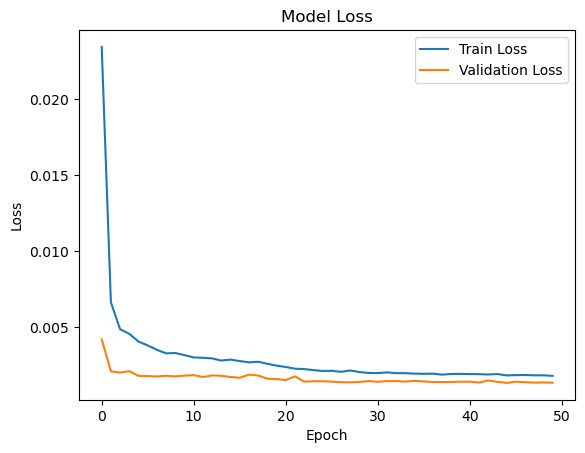

25/25 [==============================] - 1s 7ms/step


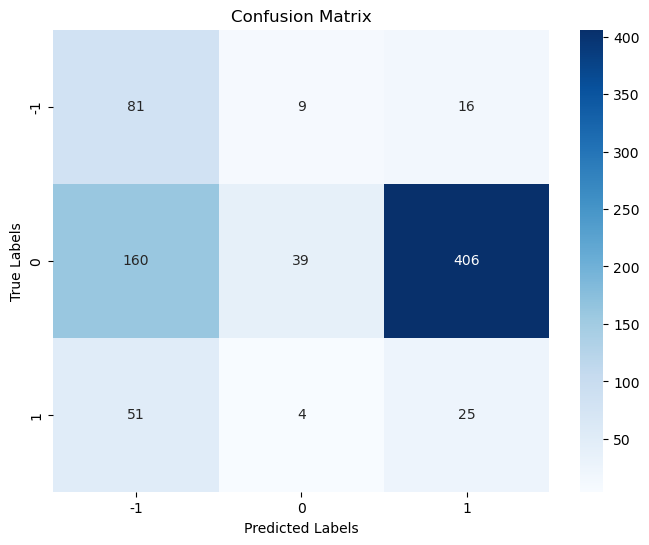

Classification Metrics:
Accuracy: 0.18
Precision: 0.36
Recall: 0.38
F1 Score: 0.21

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.28      0.76      0.41       106
           0       0.75      0.06      0.12       605
           1       0.06      0.31      0.09        80

    accuracy                           0.18       791
   macro avg       0.36      0.38      0.21       791
weighted avg       0.62      0.18      0.15       791

for borrowing rate and UNIUSDT


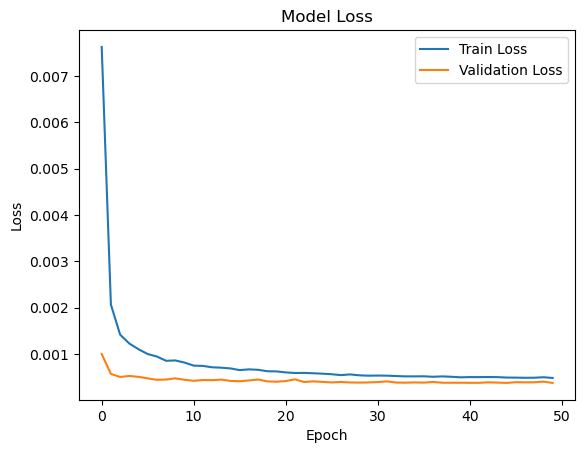

25/25 [==============================] - 1s 7ms/step


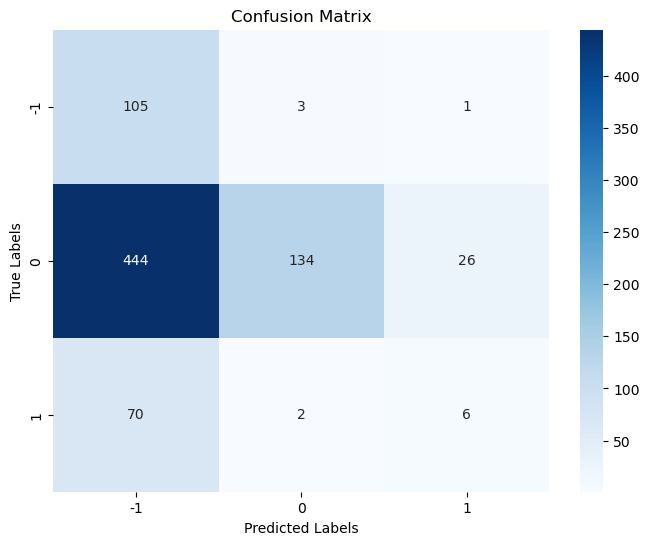

Classification Metrics:
Accuracy: 0.31
Precision: 0.44
Recall: 0.42
F1 Score: 0.25

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.17      0.96      0.29       109
           0       0.96      0.22      0.36       604
           1       0.18      0.08      0.11        78

    accuracy                           0.31       791
   macro avg       0.44      0.42      0.25       791
weighted avg       0.78      0.31      0.33       791

CRVUSDT 28455
rows with valid returns: 27458
input size (1004, 48, 5)
output size (1004, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and CRVUSDT


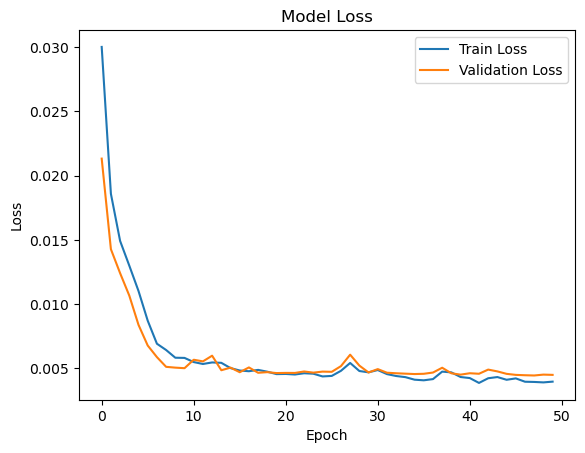

7/7 [==============================] - 1s 7ms/step


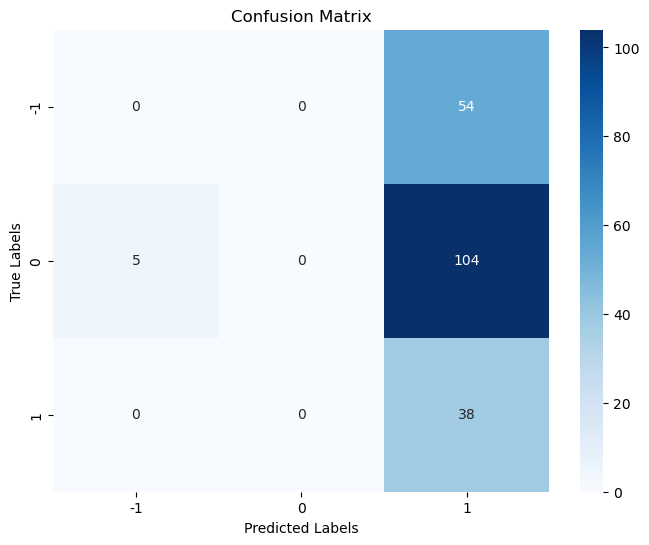

Classification Metrics:
Accuracy: 0.19
Precision: 0.06
Recall: 0.33
F1 Score: 0.11

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        54
           0       0.00      0.00      0.00       109
           1       0.19      1.00      0.32        38

    accuracy                           0.19       201
   macro avg       0.06      0.33      0.11       201
weighted avg       0.04      0.19      0.06       201

for borrowing rate and CRVUSDT


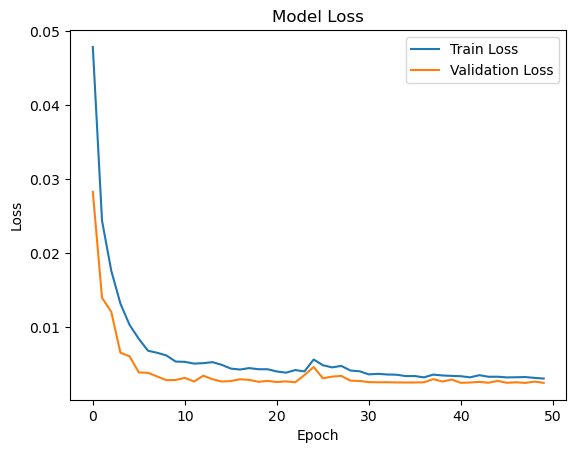

7/7 [==============================] - 1s 7ms/step


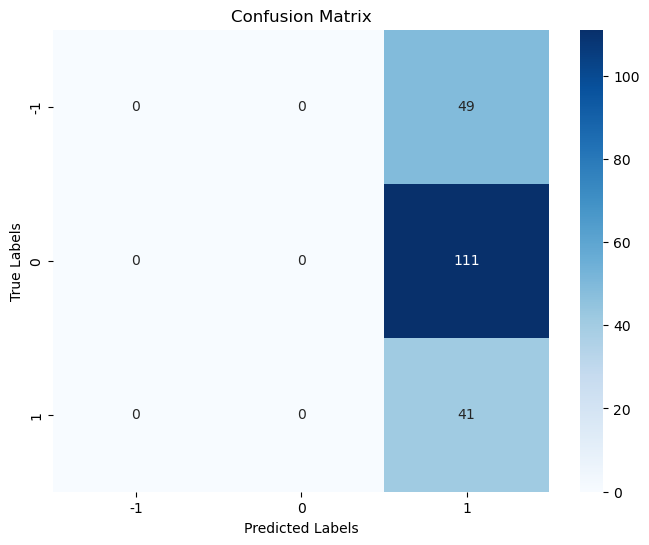

Classification Metrics:
Accuracy: 0.20
Precision: 0.07
Recall: 0.33
F1 Score: 0.11

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        49
           0       0.00      0.00      0.00       111
           1       0.20      1.00      0.34        41

    accuracy                           0.20       201
   macro avg       0.07      0.33      0.11       201
weighted avg       0.04      0.20      0.07       201

BALUSDT 24855
rows with valid returns: 24317
input size (1741, 48, 5)
output size (1741, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and BALUSDT


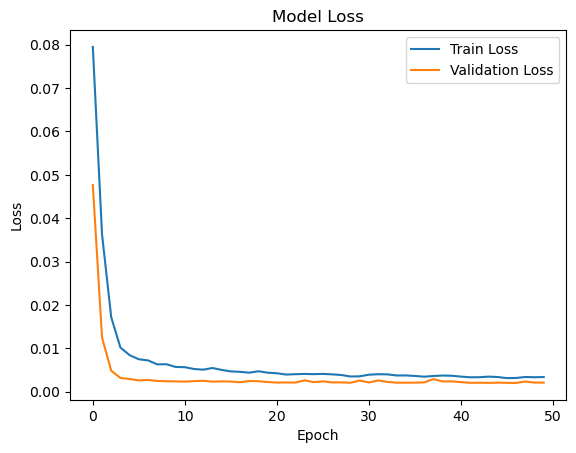

11/11 [==============================] - 1s 7ms/step


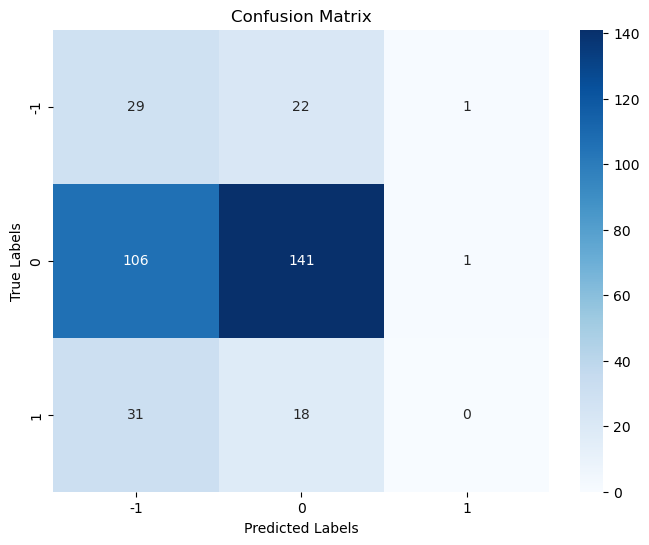

Classification Metrics:
Accuracy: 0.49
Precision: 0.32
Recall: 0.38
F1 Score: 0.31

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.17      0.56      0.27        52
           0       0.78      0.57      0.66       248
           1       0.00      0.00      0.00        49

    accuracy                           0.49       349
   macro avg       0.32      0.38      0.31       349
weighted avg       0.58      0.49      0.51       349

for borrowing rate and BALUSDT


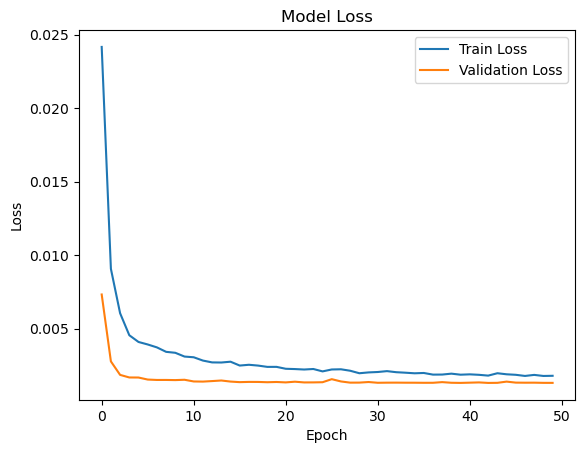

11/11 [==============================] - 1s 8ms/step


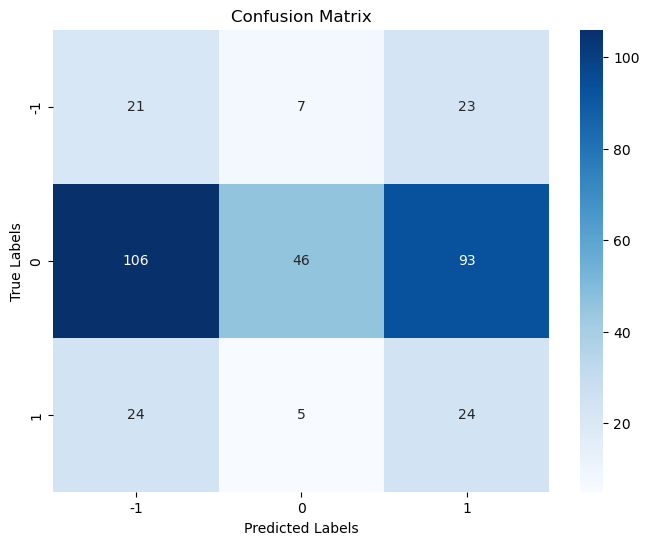

Classification Metrics:
Accuracy: 0.26
Precision: 0.37
Recall: 0.35
F1 Score: 0.25

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.14      0.41      0.21        51
           0       0.79      0.19      0.30       245
           1       0.17      0.45      0.25        53

    accuracy                           0.26       349
   macro avg       0.37      0.35      0.25       349
weighted avg       0.60      0.26      0.28       349

ENSUSDT 20745
rows with valid returns: 20574
input size (6319, 48, 5)
output size (6319, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and ENSUSDT


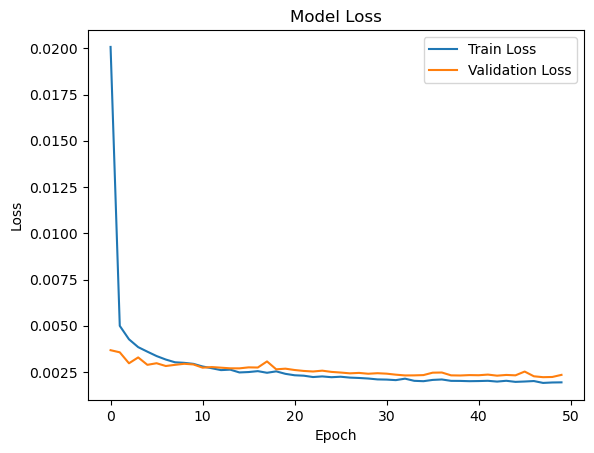

40/40 [==============================] - 1s 7ms/step


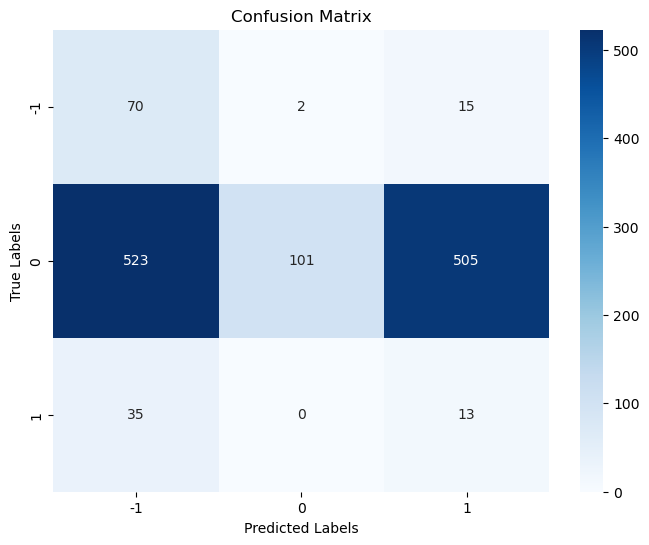

Classification Metrics:
Accuracy: 0.15
Precision: 0.37
Recall: 0.39
F1 Score: 0.13

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.11      0.80      0.20        87
           0       0.98      0.09      0.16      1129
           1       0.02      0.27      0.04        48

    accuracy                           0.15      1264
   macro avg       0.37      0.39      0.13      1264
weighted avg       0.88      0.15      0.16      1264

for borrowing rate and ENSUSDT


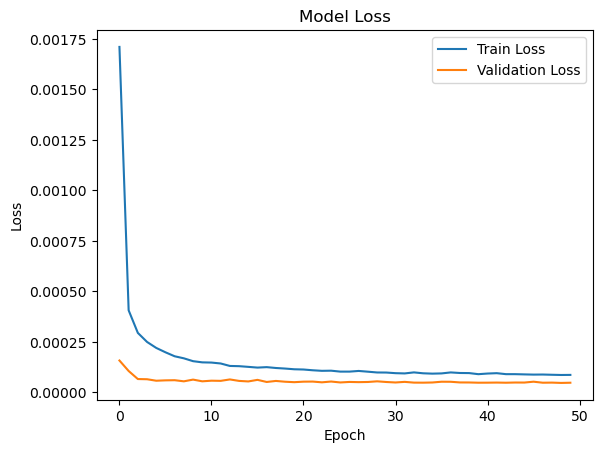

40/40 [==============================] - 1s 8ms/step


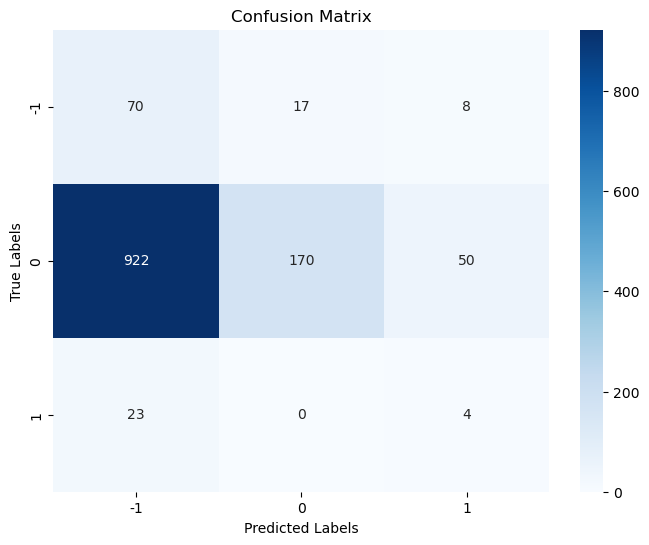

Classification Metrics:
Accuracy: 0.19
Precision: 0.35
Recall: 0.34
F1 Score: 0.16

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.07      0.74      0.13        95
           0       0.91      0.15      0.26      1142
           1       0.06      0.15      0.09        27

    accuracy                           0.19      1264
   macro avg       0.35      0.34      0.16      1264
weighted avg       0.83      0.19      0.24      1264

1INCHUSDT 14025
rows with valid returns: 13930
input size (4217, 48, 5)
output size (4217, 24, 2)
Number of NaNs in input: 0
Number of NaNs in output: 0
for lending rate and 1INCHUSDT


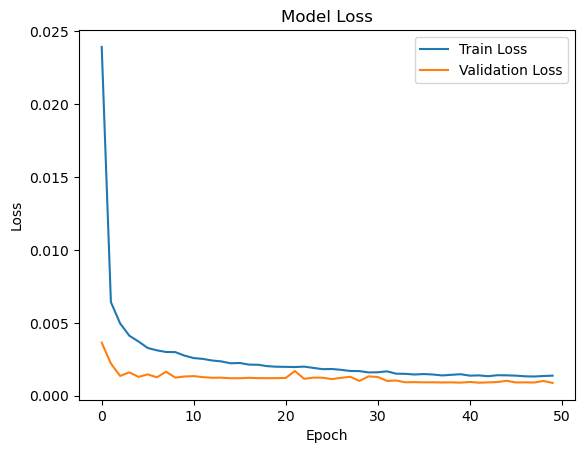

27/27 [==============================] - 1s 8ms/step


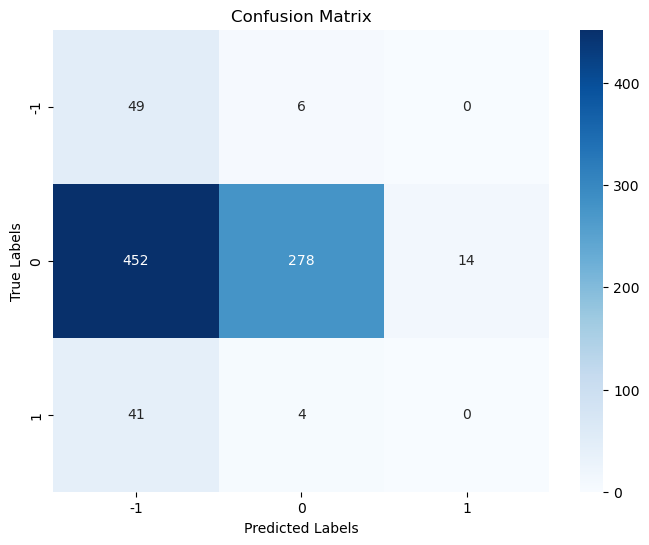

Classification Metrics:
Accuracy: 0.39
Precision: 0.35
Recall: 0.42
F1 Score: 0.23

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.09      0.89      0.16        55
           0       0.97      0.37      0.54       744
           1       0.00      0.00      0.00        45

    accuracy                           0.39       844
   macro avg       0.35      0.42      0.23       844
weighted avg       0.86      0.39      0.49       844

for borrowing rate and 1INCHUSDT


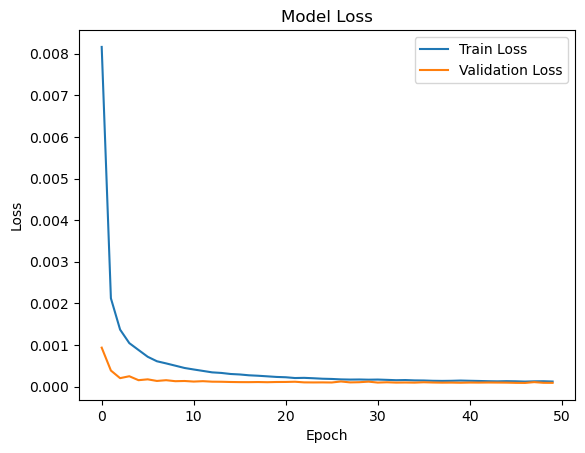

27/27 [==============================] - 1s 7ms/step


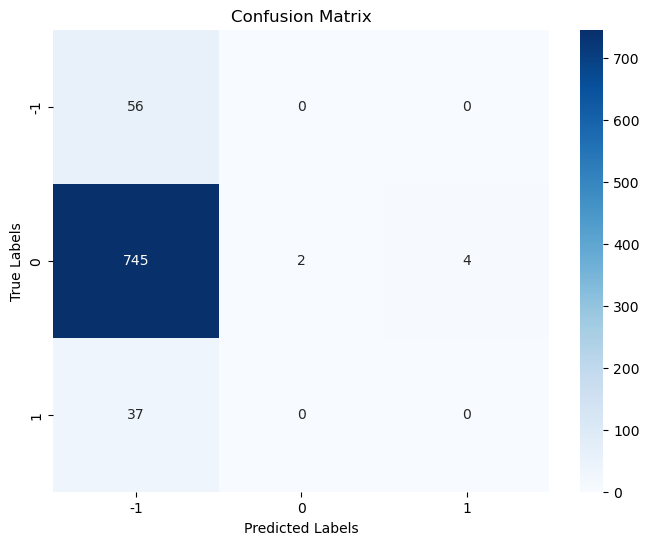

Classification Metrics:
Accuracy: 0.07
Precision: 0.36
Recall: 0.33
F1 Score: 0.04

Detailed Classification Report:
              precision    recall  f1-score   support

          -1       0.07      1.00      0.13        56
           0       1.00      0.00      0.01       751
           1       0.00      0.00      0.00        37

    accuracy                           0.07       844
   macro avg       0.36      0.33      0.04       844
weighted avg       0.89      0.07      0.01       844



In [33]:
results_df = pd.DataFrame(columns = ['symbol', 'rate', 'accuracy', 'precision', 'recall', 'f1'])
# looping through symbols
symbols = filtered_df['crypto_symbol'].unique()
for s in symbols:
     try:
          sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
          sim_df.reset_index(inplace=True, drop=True)
          print(s, len(sim_df))
          # First Loop: Calculate intervals for each column without modifying the DataFrame
          intervals = {}
          for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
               lower, upper = pre.calculate_iqr_bounds(sim_df[column])
               intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

          # getting the returns
          reduced_df = sim_df.copy()
          reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
          reduced_df = reduced_df[reduced_df['returns'].notna()]
          print('rows with valid returns:', len(reduced_df))
          reduced_df.reset_index(inplace=True, drop=True)

          # Second Loop: Filter rows based on the pre-calculated intervals
          for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
               lower_bound = intervals[column]['lower_bound']
               upper_bound = intervals[column]['upper_bound']
               # Apply filtering based on pre-calculated bounds
               reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

          reduced_df.reset_index(inplace=True, drop=True)

          # MinMax scaling
          scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

          scaled_df = reduced_df.copy()
          scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
          scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
          scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
          scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
          scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
          scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

          inputs, targets = pre.extract_valid_windows(
               scaled_df,
               'date', 
               48, 24, 
               ['lending_rate',	'borrowing_rate','utilization_rate','returns', 'volume'], 
               ['lending_rate','borrowing_rate']
               )


          print('input size', inputs.shape)
          print('output size', targets.shape)

          # Count NaNs in input and output
          input_nans = np.isnan(inputs).sum()
          output_nans = np.isnan(targets).sum()

          print(f"Number of NaNs in input: {input_nans}")
          print(f"Number of NaNs in output: {output_nans}")

          # lending_rate
          output_1 = targets[:, :, 0].reshape(targets.shape[0], targets.shape[1], 1)  # First column
          # borrowing rate
          output_2 = targets[:, :, 1].reshape(targets.shape[0], targets.shape[1], 1)  # Second column

          print('for lending rate and', s)
          y_test, test_predictions = train_and_evaluate(inputs, output_1)
          growth_data, growth_prediction = rate_growth(y_test, test_predictions)
          accuracy, precision, recall, f1 = classification_metrics(growth_data, growth_prediction)
          new_row = {
               'symbol':s, 
               'rate':'lending rate', 
               'accuracy':accuracy,
               'precision':precision, 
               'recall':recall, 
               'f1':f1
          }

          results_df.loc[len(results_df)] = new_row

          print('for borrowing rate and', s)
          y_test, test_predictions = train_and_evaluate(inputs, output_2)
          growth_data, growth_prediction = rate_growth(y_test, test_predictions)
          accuracy, precision, recall, f1 = classification_metrics(growth_data, growth_prediction)
          new_row = {
               'symbol':s, 
               'rate':'borrowing rate', 
               'accuracy':accuracy,
               'precision':precision, 
               'recall':recall, 
               'f1':f1
          }

          results_df.loc[len(results_df)] = new_row
     except Exception as e:
        # Handle any other exceptions
        print(f"Unexpected error in symbol {s}: {e}")
     

In [34]:
results_df

,symbol,rate,accuracy,precision,recall,f1
0,BATUSDT,lending rate,0.170660,0.356923,0.375356,0.171868
1,BATUSDT,borrowing rate,0.246455,0.375570,0.450873,0.215377
2,LINKUSDT,lending rate,0.153451,0.322683,0.339264,0.134355
3,LINKUSDT,borrowing rate,0.171706,0.329634,0.328588,0.172652
4,KNCUSDT,lending rate,0.136187,0.338321,0.353875,0.131955
5,KNCUSDT,borrowing rate,0.130350,0.376972,0.332855,0.133640
6,MKRUSDT,lending rate,0.423152,0.362880,0.475813,0.269053
7,MKRUSDT,borrowing rate,0.440811,0.346210,0.400305,0.268859
8,MANAUSDT,lending rate,0.318182,0.377994,0.447621,0.261669
9,MANAUSDT,borrowing rate,0.108392,0.310900,0.435031,0.122107


In [35]:
results_df[results_df['rate'] == 'lending rate'].iloc[:,2:].mean()

accuracy     0.286608
precision    0.332227
recall       0.404002
f1           0.220245
dtype: float64

In [36]:
results_df[results_df['rate'] == 'borrowing rate'].iloc[:,2:].mean()

accuracy     0.237193
precision    0.347994
recall       0.375700
f1           0.190957
dtype: float64

### End of Notebook